***Mohammad Amin Amiri ***

### Deep learning on FashionMNIST dataset using Pytorch. We will build a Convolutional Neural Network for predicting the classes of Dataset.

# **Importing Important Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision #for vision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

### If the GPU is available use it for the computation otherwise use the CPU.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2. Using FashionMNIST class from torchvision module.


*   It will download the dataset first time.




In [3]:
###COMPLETE here
train_set = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))


In [4]:
###COMPLETE here
### batch_size = 100
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=True)


### We have 10 types of clothes in FashionMNIST dataset.


> Making a method that return the name of class for the label number.
ex. if the label is 5, we return Sandal.



In [5]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

### Playing with data and displaying some images using matplotlib imshow() method.





9


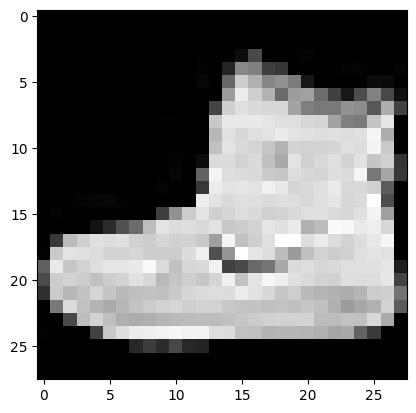

In [6]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)



*   Make a model class (FashionCNN in our case)
    * It inherit nn.Module class that is a super class for all the neural networks in Pytorch.
* Our Neural Net has following layers:
    * Two Sequential layers each consists of following layers-
        * Convolution layer that has kernel size of 3 * 3, padding = 1 (zero_padding) in 1st layer and padding = 0 in second one. Stride of 1 in both layer.
        * Batch Normalization layer.
        * Acitvation function: ReLU.
        * Max Pooling layer with kernel size of 2 * 2 and stride 2.
     * Flatten out the output for dense layer(a.k.a. fully connected layer).
     * 3 Fully connected layer  with different in/out features.
     * 1 Dropout layer that has class probability p = 0.25.
  
     * All the functionaltiy is given in forward method that defines the forward pass of CNN.
     * Our input image is changing in a following way:
        * First Convulation layer : input: 28 \* 28 \* 3, output: 28 \* 28 \* 32
        * First Max Pooling layer : input: 28 \* 28 \* 32, output: 14 \* 14 \* 32
        * Second Conv layer : input : 14 \* 14 \* 32, output: 12 \* 12 \* 64
        * Second Max Pooling layer : 12 \* 12 \* 64, output:  6 \* 6 \* 64
    * Final fully connected layer has 10 output features for 10 types of clothes.







In [7]:
###COMPLETE here
class FashionCNN(nn.Module):

    def __init__(self):
        super(FashionCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32,kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc1 = nn.Linear(6*6*64, 500)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)

        out =  out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


### Making a model of our CNN class

*   Creating a object(model in the code)
*   Transfering it into GPU if available.
*  Defining a Loss function. we're using CrossEntropyLoss() here.
*  Using Adam algorithm for optimization purpose.



In [8]:
###COMPLETE here
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=500, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=500, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)


## Training a network and Testing it on test dataset

In [9]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

###COMPLETE here

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        # Forward pass
        outputs = model(train)
        loss = error(outputs, labels)

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()

        count += 1

    # Testing the model

        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)

                test = Variable(images.view(100, 1, 28, 28))

                outputs = model(test)

                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()

                total += len(labels)

            accuracy = (correct/total)*100
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))


Iteration: 500, Loss: 0.2710525393486023, Accuracy: 86.33999633789062%
Iteration: 1000, Loss: 0.24010056257247925, Accuracy: 89.41999816894531%
Iteration: 1500, Loss: 0.17425310611724854, Accuracy: 88.29999542236328%
Iteration: 2000, Loss: 0.1724746823310852, Accuracy: 90.38999938964844%
Iteration: 2500, Loss: 0.2237038016319275, Accuracy: 89.97000122070312%
Iteration: 3000, Loss: 0.1267584264278412, Accuracy: 90.27000427246094%


### Visualizing the Loss and Accuracy with Iterations


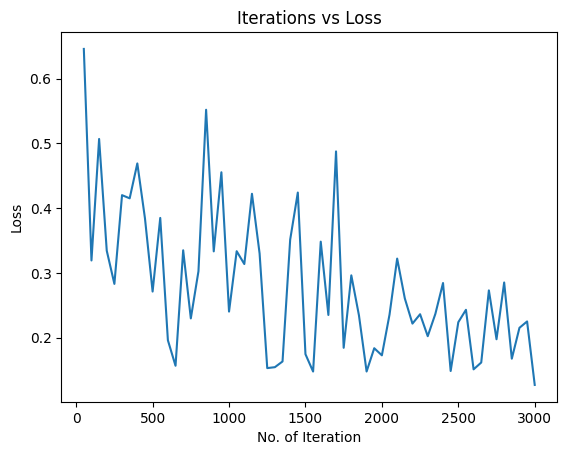

In [10]:
loss_list = [l.cpu() for l in loss_list]
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

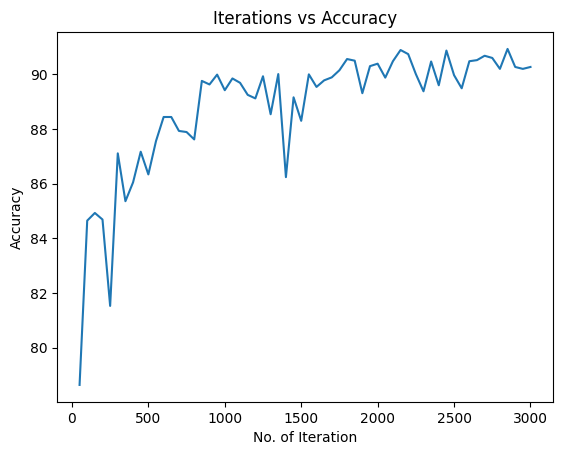

In [11]:
accuracy_list = [l.cpu() for l in accuracy_list]
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()